In [1]:
import cvxpy as cp
import numpy as np

import torch
import torch.nn as nn
from model import TwolayerNet, MLP, AbstainNet
from torch.utils.data import DataLoader
from utils import load_data

import os
import time
from options import args_parser

import matplotlib.pyplot as plt

In [2]:
class namespace:
    def __init__(self):
        self.batch_size=128
        self.device='cuda:1'
        self.epoch=30000
        self.hidden_dim=300
        self.input_dim=108
        self.load_from_disk=True
        self.lr=0.0005
        self.seed=1
        self.fairness_notion="DP"
        self.attribute="sex"
        self.type_of_abstain="prob"

args = namespace()

print(args)

args.model_path = "../data/OptimalClassifier"
args.data_path = "../data/adult"

train_data, test_data = load_data(args)

In [14]:
def load_optimal(args):
    model = MLP(args)

    checkpoint = torch.load(os.path.join(args.model_path, "model_state.pth"), map_location="cpu")
    model.load_state_dict(checkpoint)

    model.to("cpu")
    model.eval()

    return model
def load_abstain(args):
    model = AbstainNet(args)
    
    model_file = os.path.join("../data/AbstainClassifier", "abstain_classifier_" + \
                            args.type_of_abstain+"_" + \
                            args.fairness_notion + "_" + \
                            args.attribute + ".pth")
    
    checkpoint = torch.load(model_file, map_location="cpu")
    model.load_state_dict(checkpoint)
    
    model.to("cpu")
    model.eval()
    
    return model

def predict_abstain(model, data, pred_labels):
    X = data.X.numpy()
    X = np.column_stack((X, pred_labels))
    log_probs = model(torch.from_numpy(X).to(torch.float))
    return log_probs.detach().cpu().numpy().flatten()

def predict(model, data):
    log_probs = model(data.X)
    return ((log_probs[:, 1] >= 0.5) * 1).detach().cpu().numpy(), log_probs[:, 1].detach().cpu().numpy()

def formatted(numbers):
    return [f"{num*100:.2f}%" for num in numbers]
def plot_stats(
    y,
    pred_labels,
    g1_indices, 
    g2_indices,
    wprob,
    wbi,
    title="None"
):
    n = pred_labels.shape[0]
    g1_num = g1_indices.shape[0]
    g2_num = g2_indices.shape[0]
    total_error = pred_labels != y
    g1_error = (pred_labels != y)[g1_indices]
    g2_error = (pred_labels != y)[g2_indices]
    
    g1_error_rate = np.sum(g1_error) / g1_num
    g2_error_rate = np.sum(g2_error) / g2_num
    total_error_rate = np.sum(total_error) / n
    

    g1_prob_error_rate = np.sum(wprob[g1_indices] * g1_error) / np.sum(wprob[g1_indices])
    g2_prob_error_rate = np.sum(wprob[g2_indices] * g2_error) / np.sum(wprob[g2_indices])
    total_prob_error_rate = np.sum(wprob * total_error) / np.sum(wprob)

    g1_bi_error_rate = np.sum(wbi[g1_indices] * g1_error) / np.sum(wbi[g1_indices])
    g2_bi_error_rate = np.sum(wbi[g2_indices] * g2_error) / np.sum(wbi[g2_indices])
    total_bi_error_rate = np.sum(wbi * total_error) / np.sum(wbi)



    optimal_accu = [1 - total_error_rate, 1 - g1_error_rate, 1 - g2_error_rate]
    prob_accu = [
        1 - total_prob_error_rate,
        1 - g1_prob_error_rate,
        1 - g2_prob_error_rate
    ]
    bi_accu = [
        1 - total_bi_error_rate,
        1 - g1_bi_error_rate,
        1 - g2_bi_error_rate
    ]

    optimal_fairness = [
        np.sum(pred_labels) / n, 
        np.sum(pred_labels[g1_indices]) / g1_num, 
        np.sum(pred_labels[g2_indices]) / g2_num
    ]
    prob_fairness = [
        np.sum(wprob * pred_labels) / n,
        np.sum((wprob * pred_labels)[g1_indices]) / g1_num,
        np.sum((wprob * pred_labels)[g2_indices]) / g2_num,
    ]
    bi_fairness = [
        np.sum(wbi * pred_labels) / n,
        np.sum((wbi * pred_labels)[g1_indices]) / g1_num,
        np.sum((wbi * pred_labels)[g2_indices]) / g2_num,
    ]


    #Abstain rate
    optimal_abstain_rate = [0, 0, 0]
    prob_abstain_rate = [
        1 - np.sum(wprob) / n, 
        1 - np.sum(wprob[g1_indices]) / g1_num, 
        1 - np.sum(wprob[g2_indices]) / g2_num,
    ]
    bi_abstain_rate = [
        1 - np.sum(wbi) / n, 
        1 - np.sum(wbi[g1_indices]) / g1_num, 
        1 - np.sum(wbi[g2_indices]) / g2_num,
    ]

    # plt.bar(["", "b", "c"],[1 - total_error_rate, 1 - g1_error_rate, 1 - g2_error_rate])
    plt.rcParams.update({'font.size': 15})

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

    #accuracy
    bar_width = 0.25
    x_labels = ["Overall", "G1", "G2"]
    x_pos = np.arange(len(x_labels))
    ax[0,0].bar(x_pos - bar_width, optimal_accu, width=bar_width, label='Opt. Clas.')
    ax[0,0].bar(x_pos, prob_accu, width=bar_width, label='Prob.')
    ax[0,0].bar(x_pos + bar_width, bi_accu, width=bar_width, label='Binary')
    ax[0,0].set_ylim([0.85, 1])
    ax[0,0].set_ylabel("Accuracy")
    ax[0,0].set_title("Accuracy")
    ax[0,0].set_xticks(x_pos)
    ax[0,0].set_xticklabels(x_labels)
    ax[0,0].legend()


    #fairness
    bar_width = 0.25
    x_labels = ["Overall", "G1", "G2"]
    x_pos = np.arange(len(x_labels))
    ax[0,1].bar(x_pos - bar_width, optimal_fairness, width=bar_width, label='Opt. Clas.')
    ax[0,1].bar(x_pos, prob_fairness, width=bar_width, label='Prob.')
    ax[0,1].bar(x_pos + bar_width, bi_fairness, width=bar_width, label='Binary')
    # ax[0,1].set_ylim([0.85, 1])
    ax[0,1].set_ylabel('$P(\\hat{y} = 1 | G)$')
    ax[0,1].set_title("Demographic Parity")
    ax[0,1].set_xticks(x_pos)
    ax[0,1].set_xticklabels(x_labels)
    ax[0,1].legend()

    #proportion
    ax[1,0].pie([g1_num, g2_num], labels=['G1', 'G2'], autopct='%1.1f%%', startangle=90)
    ax[1,0].set_title('Proportion')

    #abstain rate
    bar_width = 0.25
    x_labels = ["Overall", "G1", "G2"]
    x_pos = np.arange(len(x_labels))
#     ax[1,1].bar(x_pos - bar_width, optimal_abstain_rate, width=bar_width, label='Opt. Clas.')
    ax[1,1].bar(x_pos, prob_abstain_rate, width=bar_width, label='Prob.')
    ax[1,1].bar(x_pos + bar_width, bi_abstain_rate, width=bar_width, label='Binary')
    # ax[0,1].set_ylim([0.85, 1])
    ax[1,1].set_ylabel('Abstain Rate')
    ax[1,1].set_title("Abstain Rate")
    ax[1,1].set_xticks(x_pos)
    ax[1,1].set_xticklabels(x_labels)
    ax[1,1].legend()


    fig.suptitle(args.attribute + " as Sensitive Attribute(G1=Male, G2=Female, "+ '$\delta=$' + str(delta) + ', $\epsilon=$' + str(epsilon) +")", fontsize=30)

    fig.savefig(title)
    
    print("==Optimal Classifier==\n")
    print("Accuracy", " ".join(formatted(optimal_accu)))
    print("P(\hat{y} = 1 | G)", " ".join(formatted(optimal_fairness)))
    print("Abstain Rate", " ".join(formatted(optimal_abstain_rate)))

    print()

    print("==Abstain with Probability==\n")
    print("Accuracy", " ".join(formatted(prob_accu)))
    print("P(\hat{y} = 1 | G)", " ".join(formatted(prob_fairness)))
    print("Abstain Rate", " ".join(formatted(prob_abstain_rate)))

    print()

    print("==Abstain as Binary==\n")
    print("Accuracy", " ".join(formatted(bi_accu)))
    print("P(\hat{y} = 1 | G)", " ".join(formatted(bi_fairness)))
    print("Abstain Rate", " ".join(formatted(bi_abstain_rate)))

In [4]:
data = train_data
optimal_classifier = load_optimal(args)
pred_labels, pred_probs = predict(optimal_classifier, data)
np.save("../data/adult/optimal_labels.npy", pred_labels)
pred_labels_test, _ = predict(optimal_classifier, test_data)
np.save("../data/adult/test_optimal_labels.npy", pred_labels_test)

In [5]:
X = data.X.numpy()
y = data.y.numpy().astype(int)

n = X.shape[0]
g2_indices = np.where(X[:, 64] == 1)[0]
g1_indices = np.where(X[:, 65] == 1)[0]

g1_num = g1_indices.shape[0]
g2_num = g2_indices.shape[0]
total_error = pred_labels != y
g1_error = (pred_labels != y)[g1_indices]
g2_error = (pred_labels != y)[g2_indices]
g1_error_rate = np.sum(g1_error) / g1_num
g2_error_rate = np.sum(g2_error) / g2_num
total_error_rate = np.sum(total_error) / n

**LP Optimazation**

In [6]:
def LP(delta, epsilon, eta, data):
    X = data.X.numpy()
    y = data.y.numpy().astype(int)

    n = X.shape[0]
    g2_indices = np.where(X[:, 64] == 1)[0]
    g1_indices = np.where(X[:, 65] == 1)[0]

    g1_num = g1_indices.shape[0]
    g2_num = g2_indices.shape[0]
    total_error = pred_labels != y
    g1_error = (pred_labels != y)[g1_indices]
    g2_error = (pred_labels != y)[g2_indices]
    g1_error_rate = np.sum(g1_error) / g1_num
    g2_error_rate = np.sum(g2_error) / g2_num
    total_error_rate = np.sum(total_error) / n
    w = cp.Variable(n)

    objective = cp.Minimize(cp.sum(cp.multiply(total_error, w)))

    constraints = [
        w <= 1,
        w >= 0,
        (cp.sum(cp.multiply(w, pred_labels)[g1_indices]) / g1_num - cp.sum(cp.multiply(w, pred_labels)[g2_indices]) / g2_num) ** 2 <= epsilon ** 2,
        cp.sum(w[g1_indices]) >= (1 - delta) * g1_num,
        cp.sum(w[g2_indices]) >= (1 - delta) * g2_num,
        cp.sum(cp.multiply(w[g1_indices], g1_error)) <= (g1_error_rate + eta) * cp.sum(w[g1_indices]),
        cp.sum(cp.multiply(w[g2_indices], g2_error)) <= (g2_error_rate + eta) * cp.sum(w[g2_indices]),
    ]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    wn = w.value
    
    return wn

**Generate g for test data**

In [7]:
optimal_classifier = load_optimal(args)
abstain_classifier = load_abstain(args)
pred_labels, _ = predict(optimal_classifier, train_data)
pred_labels_test, _ = predict(optimal_classifier, test_data)
abstain_probs = predict_abstain(abstain_classifier, train_data, pred_labels)
abstain_probs_test = predict_abstain(abstain_classifier, test_data, pred_labels_test)

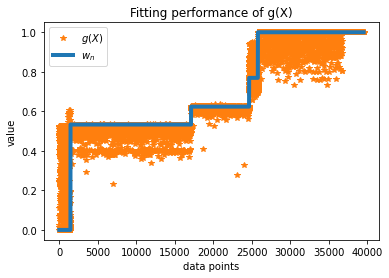

In [11]:
wn = LP(0.3, 0.03, 0.0, train_data)
combo = np.stack([wn, abstain_probs]).T
combo = combo[combo[:,0].argsort()]
plt.plot(combo[:, 1], "*", label = "$g(X)$", color="#ff7f0e")
plt.plot(combo[:, 0], linewidth=4, label = "$w_n$", color="#1f77b4")
plt.legend()
plt.title("Fitting performance of g(X)")
plt.xlabel("data points")
plt.ylabel("value")
plt.savefig("wn_gx_lp.png")

**Visualization**

In [12]:
delta = 0.3
epsilon = 0.03
eta = 0

Use wn as abstain result

==Optimal Classifier==

Accuracy 93.21% 92.30% 95.69%
P(\hat{y} = 1 | G) 49.35% 58.01% 25.92%
Abstain Rate 0.00% 0.00% 0.00%

==Abstain with Probability==

Accuracy 96.51% 95.71% 98.68%
P(\hat{y} = 1 | G) 28.17% 28.99% 25.92%
Abstain Rate 30.10% 29.95% 30.51%

==Abstain as Binary==

Accuracy 96.75% 95.90% 99.05%
P(\hat{y} = 1 | G) 46.61% 54.25% 25.92%
Abstain Rate 3.66% 3.76% 3.39%


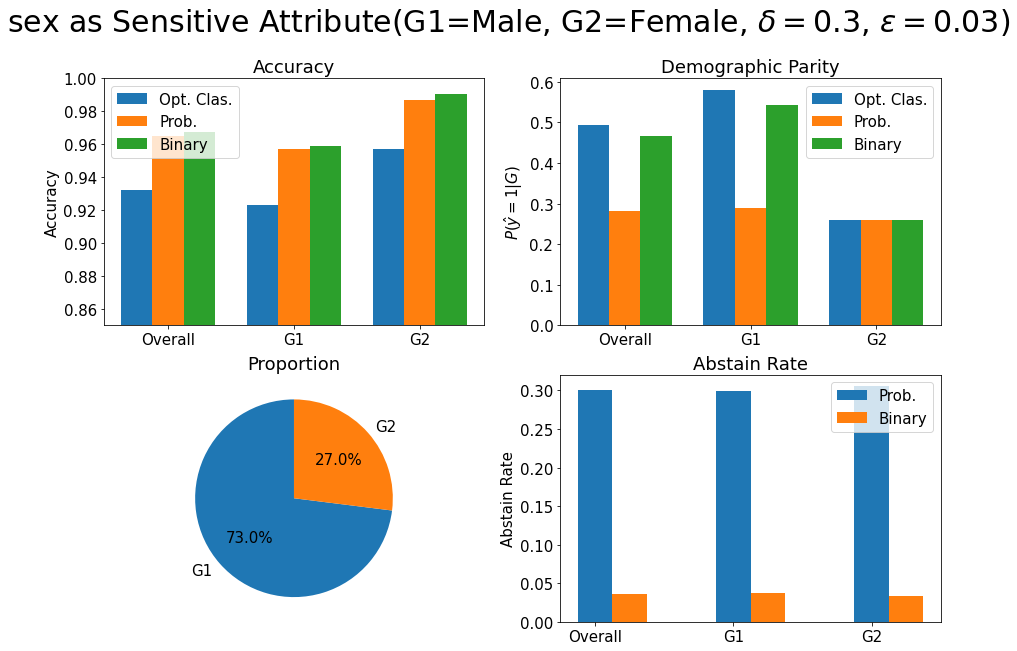

In [15]:
print("Use wn as abstain result\n")
X = train_data.X.numpy()
y = train_data.y.numpy().astype(int)
g2_indices = np.where(X[:, 64] == 1)[0]
g1_indices = np.where(X[:, 65] == 1)[0]
#draw decision with probability wn
wn = LP(delta, epsilon, eta, train_data)
wprob = (np.random.rand(len(wn)) < wn) * 1
#use wn as binary classifier
wbi = (wn >= 0.5) * 1
plot_stats(
    y,
    pred_labels,
    g1_indices, 
    g2_indices,
    wprob,
    wbi,
    "train_wn.png"
)

Use g(X) as abstain result

==Optimal Classifier==

Accuracy 93.21% 92.30% 95.69%
P(\hat{y} = 1 | G) 49.35% 58.01% 25.92%
Abstain Rate 0.00% 0.00% 0.00%

==Abstain with Probability==

Accuracy 94.93% 93.66% 98.37%
P(\hat{y} = 1 | G) 28.70% 29.73% 25.92%
Abstain Rate 29.51% 29.43% 29.71%

==Abstain as Binary==

Accuracy 95.92% 94.80% 98.90%
P(\hat{y} = 1 | G) 45.07% 52.15% 25.92%
Abstain Rate 5.17% 5.87% 3.27%


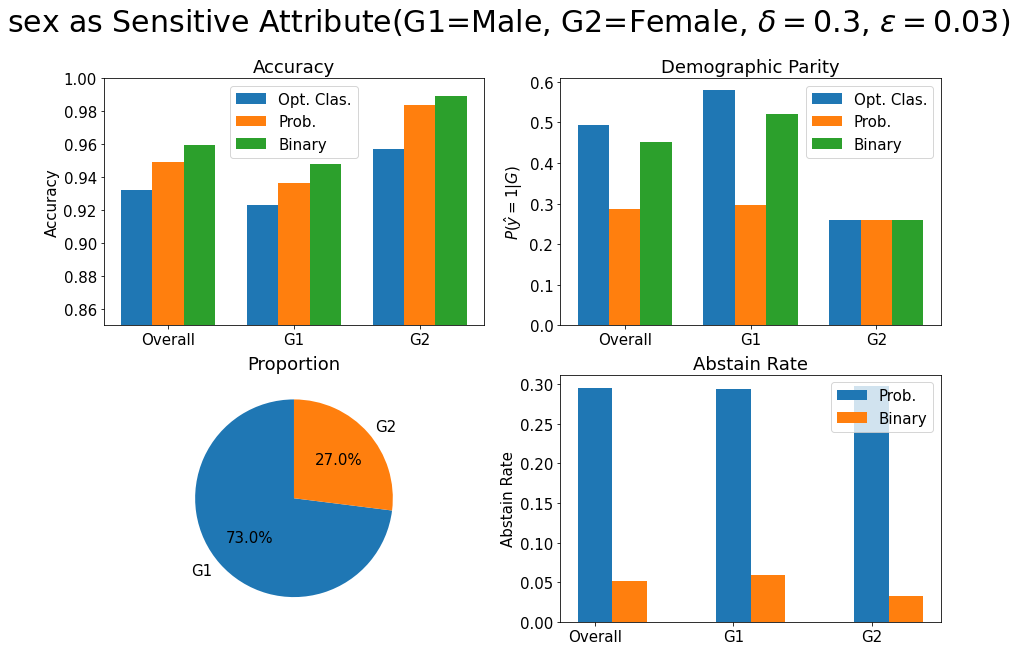

In [16]:
print("Use g(X) as abstain result\n")

#draw decision with probability g(X)
y = train_data.y.numpy()
wn = abstain_probs
wprob = (np.random.rand(len(wn)) < wn) * 1
#use g(X) as binary classifier
wbi = (wn >= 0.5) * 1
plot_stats(
    y,
    pred_labels,
    g1_indices, 
    g2_indices,
    wprob,
    wbi,
    "train_gx.png"
)

Performance on test data

==Optimal Classifier==

Accuracy 89.57% 88.27% 93.14%
P(\hat{y} = 1 | G) 49.79% 58.77% 25.12%
Abstain Rate 0.00% 0.00% 0.00%

==Abstain with Probability==

Accuracy 90.66% 89.23% 94.66%
P(\hat{y} = 1 | G) 28.72% 30.03% 25.12%
Abstain Rate 30.24% 29.92% 31.11%

==Abstain as Binary==

Accuracy 91.06% 89.16% 96.22%
P(\hat{y} = 1 | G) 46.14% 53.79% 25.12%
Abstain Rate 4.63% 4.98% 3.68%


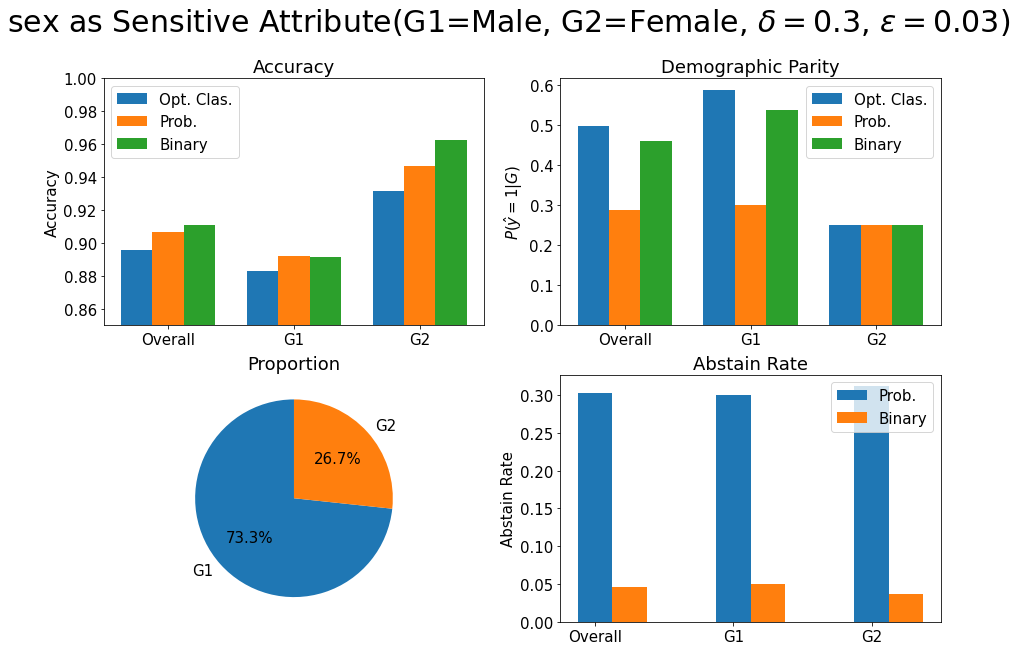

In [17]:
print("Performance on test data\n")

X = test_data.X.numpy()
y = test_data.y.numpy().astype(int)

n = y.shape[0]
g2_indices_test = np.where(X[:, 64] == 1)[0]
g1_indices_test = np.where(X[:, 65] == 1)[0]
#draw decision with probability g(X)
wn_test = abstain_probs_test
wprob_test = (np.random.rand(len(wn_test)) < wn_test) * 1
#use g(X) as binary classifier
wbi_test = (wn_test >= 0.5) * 1
plot_stats(
    y,
    pred_labels_test,
    g1_indices_test, 
    g2_indices_test,
    wprob_test,
    wbi_test,
    "test_gx.png"
)
